# Exploring my locations recorded by Google

Google can give you all your recorded locations. The locations are all stored in a JSON file which is not very easy to visualize but handy to process ! In this notebook I'll write a script using Google API (on Google Clouds) to produce a nice map.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from datetime import date
from os.path import join
from pprint import pprint
from tqdm import tqdm

# map visualisation with Google Api
import bokeh
from bokeh.io import output_file, output_notebook, show, reset_output, save
from bokeh.plotting import gmap
from bokeh.models.markers import Circle
from bokeh.models import (
  GMapPlot, GMapOptions, ColumnDataSource, LogColorMapper, BasicTicker, ColorBar,
    DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, Range1d
)
from bokeh.models.mappers import ColorMapper, LinearColorMapper
from bokeh.palettes import OrRd, Viridis5

## 1. My locations, by Google Maps.

### 1.1 Load locations from json

In [2]:
# path to json
path = r'C:\Users\Louis\Documents\PersonalData'
takeouts = os.listdir(path)
takeout = takeouts[1]
takeout_path = join(path,takeout,'Takeout')
json_path = join(takeout_path,'Historique des positions','Historique des positions.json')
print(f"JSON path : \n{json_path}\n")

# opening JSON
with open(json_path) as json_file:
    print("Loading data...")
    data = json.load(json_file)

# counting samples
nb_loc = len(data['locations'])
print(f"{nb_loc} locations recorded.\n")

# example
print("Example of recorded location :")
pprint(data['locations'][0])

JSON path : 
C:\Users\Louis\Documents\PersonalData\takeout-20190611T194630Z-001\Takeout\Historique des positions\Historique des positions.json

Loading data...
188096 locations recorded.

Example of recorded location :
{'accuracy': 24,
 'latitudeE7': 506719330,
 'longitudeE7': 30930719,
 'timestampMs': '1389308910440'}


We can see that Google has a lot os locations about me. For each location we have a (longitude, latitude) stored as integers. We need to divide these values by $10^7$. And a timestamp stored as an integer which is a count os milliseconds. We need to divide this value by $10^3$ to get a standard timestamp.

### 1.2 Converting JSON to CSV

In [48]:
# init dataframe
df = pd.DataFrame(
    data=np.zeros((nb_loc,4)),
    columns=['lat','lng','tim','year'],
)

# filling dataframe
for ind, pos in tqdm(enumerate(data['locations']),total= nb_loc):
    lat = pos['latitudeE7']
    lng = pos['longitudeE7']
    tim = pos['timestampMs']
    df.lat[ind] = lat/10**7
    df.lng[ind] = lng/10**7
    df.tim[ind] = int(tim)/1000 # convert ms into s
    df.year[ind] = date.fromtimestamp(int(tim)/1000).year

# saving DataFrame
df.to_csv('locations.csv')
print("Dataframe saved.")

df.head(10)

100%|█████████████████████████████████| 188096/188096 [12:21<00:00, 253.63it/s]


Dataframe saved.


,lat,lng,tim,year
0,50.671933,3.093072,1.389309e+09,2014.0
1,50.671933,3.093072,1.389309e+09,2014.0
2,50.671924,3.093023,1.389309e+09,2014.0
3,50.671924,3.093023,1.389309e+09,2014.0
4,50.671923,3.093027,1.389309e+09,2014.0
5,50.671900,3.093064,1.389309e+09,2014.0
6,50.671900,3.093061,1.389309e+09,2014.0
7,50.671933,3.093072,1.389309e+09,2014.0
8,50.671900,3.093064,1.389309e+09,2014.0
9,50.671900,3.093061,1.389310e+09,2014.0


## 2. Show on map with Google API

In [3]:
# load dataframe
df = pd.read_csv('locations.csv')
nb_loc = df.shape[0]
print(f"Dataframe of {nb_loc} locations loaded.")

with open('google_api_key.txt','r') as f:
    google_api_key = f.read()

Dataframe of 188096 locations loaded.


###  2.1 Dates of data recording

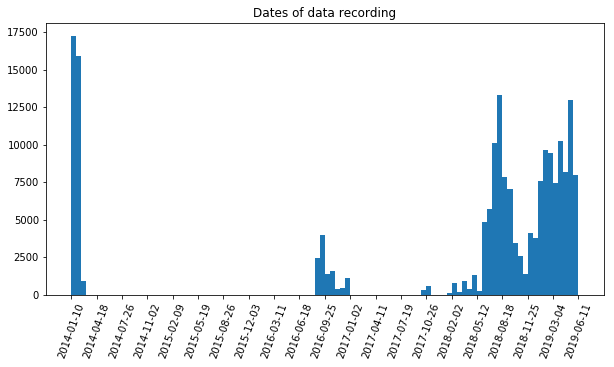

In [5]:
plt.figure(figsize=(10,5))
plt.title('Dates of data recording')
plt.hist(
    df.tim,
    bins=100,
#     label=dates,
)
n_bins_labels = 20
hist, edges = np.histogram(df.tim, bins=n_bins_labels)
dates = [str(date.fromtimestamp(a)) for a in edges]
plt.xticks(edges, dates, rotation=70)
plt.show()

Big periods of data are missing. I suppose I've only let Google collect my locations on these periods.

###  2.2 Visualization on a map

Google API gives us a very nice way to use this data with Google Maps. To do this you need a google api key, which is free, and an account on Google Cloud, which is free at least for 12 months.

In [6]:
# init map options
map_options = GMapOptions(
#     lat=48.8, lng=2.3, # Centered on Paris, France.
#     lat=50.66, lng=3.1, # Centered on Lille, France.
   lat=59.95, lng=30.31, # Centered on Saint-Petersburg, Russia.
    map_type="roadmap", 
    zoom=12,
)

# init map
plot = GMapPlot(
    x_range=Range1d(), 
    y_range=Range1d(), 
    map_options=map_options,
)
plot.title.text = "My life, by Google."
plot.api_key = google_api_key

# load locations
PROPORTION = 0.05
index = np.random.uniform(0,1,size=(nb_loc,1)) < PROPORTION
source = ColumnDataSource(
    data=dict(
        lat=df.lat.tolist(),
        lng=df.lng.tolist(),
        #tim=df.tim.tolist(),
        year=df.year.tolist(),
    )
#     data = df[index],
)

max_year = df.loc[df['year'].idxmax()]['year']
min_year = df.loc[df['year'].idxmin()]['year']

color_mapper = LogColorMapper(
#     palette="Viridis5", 
#     palette=bokeh.palettes.Plasma[max_year-min_year],
    palette=bokeh.palettes.Set2[max_year-min_year],
    low=min_year, 
    high=max_year,
)
color_bar = ColorBar(
    color_mapper=color_mapper, 
    ticker=BasicTicker(),
    label_standoff=12, 
    border_line_color=None, 
    location=(0,0),
)
plot.add_layout(color_bar, 'right')

# put everything on the map

# use markers
circle = Circle(
    x="lng", 
    y="lat", 
    size=4,
    line_color=None,
    fill_color={'field': 'year', 'transform': color_mapper},
    fill_alpha=0.4,
)
plot.add_glyph(source, circle)

# add tools to map
plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())

#save map
save(plot)
output_file("gmap_plot.html")
# show(plot)

I've spent four months in Saint-Petersburg in 2018. Here is the result of the above code for my personal data. I won't share more than this ;)

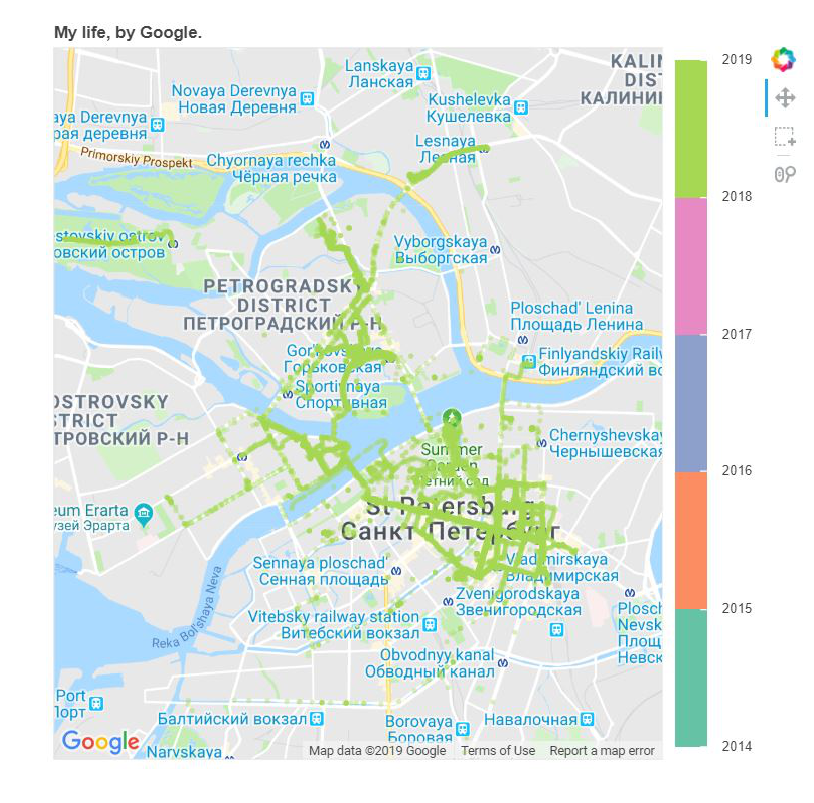

In [9]:
from skimage.io import imread
img = imread('stpet_maps.JPG')
plt.figure(figsize=(10,10),dpi=100)
plt.imshow(img)
plt.axis('off')
plt.show()

#### Conclusion

This is very impressive. Locations are numerous and precise. If you go on google maps you can see "Your Itininaries" which is funny because you have a few dots on a map, but it's more scary with hundreds of thousanrds of dot on a map showing every places you've visited. I think it's worth exploring your data to realize this.